In [1268]:
import io
import pandas as pd
from google.colab import files
import numpy as np
# uploaded = files.upload()


movie_dataframe = pd.read_csv('raw_data.csv') # store cvc file as dataframe
# print(movie_dataframe)

In [1269]:
movie_dataframe = movie_dataframe.drop('MPAA Rating', axis=1) # remove MPAA Rating field as there are too many null values
movie_dataframe = movie_dataframe.dropna()
print(movie_dataframe.isnull().sum()) # check null values

Unnamed: 0           0
Director Name        0
Title                0
Budget               0
Box Office           0
Rating               0
Number of Ratings    0
Genre                0
Date of Release      0
Production House     0
Runtime              0
dtype: int64


In [1270]:
movie_dataframe = movie_dataframe.drop_duplicates() #remove duplicate rows if there are any
# print(movie_dataframe)

In [1271]:
movie_dataframe['Budget'] = pd.to_numeric(movie_dataframe['Budget'], errors='coerce') # convert to int if, it isnt already
movie_dataframe['Box Office'] = pd.to_numeric(movie_dataframe['Box Office'], errors='coerce')
movie_dataframe['Date of Release'] = pd.to_datetime(movie_dataframe['Date of Release'], errors='coerce') # convert to date, if it isnt already

# Replace missing values in numerical columns with mean
numeric_cols = movie_dataframe.select_dtypes(include=['int', 'float']).columns
movie_dataframe[numeric_cols] = movie_dataframe[numeric_cols].fillna(movie_dataframe[numeric_cols].mean())

# Rename columns to remove spaces
# movie_dataframe.columns = movie_dataframe.columns.str.replace(' ', '')

print(movie_dataframe.isnull().sum()) #check null after conversion, as there might be some now

Unnamed: 0           0
Director Name        0
Title                0
Budget               0
Box Office           0
Rating               0
Number of Ratings    0
Genre                0
Date of Release      0
Production House     0
Runtime              0
dtype: int64


In [1272]:
# Count the number of rows where both 'Box Office' and 'Budget' are 0
zero_values_count = movie_dataframe[(movie_dataframe['Box Office'] == 0) & (movie_dataframe['Budget'] == 0)].shape[0]

print(f"Number of rows where Box Office and Budget are both 0: {zero_values_count}")

Number of rows where Box Office and Budget are both 0: 5289


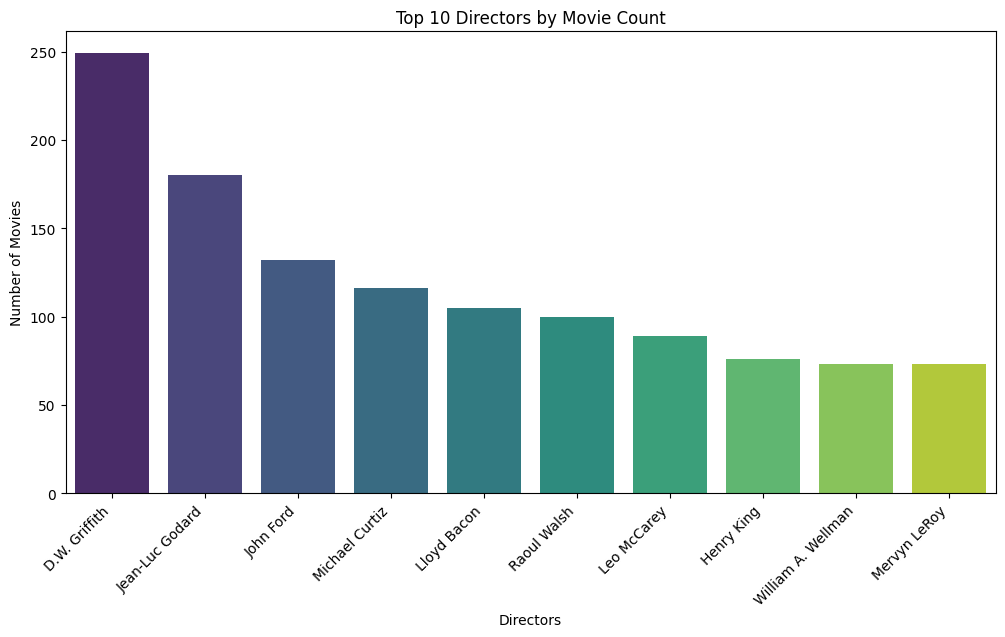

In [1273]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you want to show the top 10 directors
top_directors = movie_dataframe['Director Name'].value_counts().nlargest(10)

# Create a bar plot for the top directors
plt.figure(figsize=(12, 6))
sns.barplot(x=top_directors.index, y=top_directors.values, palette='viridis')
plt.title('Top 10 Directors by Movie Count')
plt.xlabel('Directors')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [1274]:
total_directors = movie_dataframe['Director Name'].nunique()
# Display the total number of unique directors
print(f"Total number of directors: {total_directors}")

Total number of directors: 244


In [1275]:
# movie_dataframe['Box Office to Budget Ratio'] = movie_dataframe.apply(lambda row: row['Box Office'] / row['Budget'] if row['Budget'] != 0 else 0, axis=1)

# # print(movie_dataframe['Box Office to Budget Ratio'])

# # Group by director and calculate the average box office to budget ratio
# director_stats = movie_dataframe.groupby('Director Name').agg({'Box Office to Budget Ratio': 'mean', 'Title': 'count'}).reset_index()

# # Get the top 10 directors based on the average box office to budget ratio
# top_directors = director_stats.nlargest(10, 'Box Office to Budget Ratio')



# # Create a bar plot for the top directors
# plt.figure(figsize=(12, 6))
# sns.barplot(x='Director Name', y='Box Office to Budget Ratio', data=top_directors, palette='viridis')
# plt.title('Top 10 Directors by Average Box Office to Budget Ratio')
# plt.xlabel('Directors')
# plt.ylabel('Average Box Office to Budget Ratio')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.show()

In [1276]:
print(movie_dataframe.columns.tolist())

['Unnamed: 0', 'Director Name', 'Title', 'Budget', 'Box Office', 'Rating', 'Number of Ratings', 'Genre', 'Date of Release', 'Production House', 'Runtime']


In [1277]:
# calculating success in terms of popularity
# using formula:
# success_popularity = rating * log(number_of_ratings)
# this takes into account both the actual rating, and how many ratings the movie got
# log is used to normalize the number of ratings, as some movies might have too many ratings
# 1 is inside the log to prevent log(0) from happening for any potential movies with no ratings
movie_dataframe['success_popularity'] = movie_dataframe['Rating'] * np.log(movie_dataframe['Number of Ratings'] + 1)

In [1278]:
# calculating success in terms of popularity
# using formula:
# ROI * log(absolute profit)
# where ROI (return on investment) = ((box office - budget)/budget) * 100
# and absolute profit = box office - budget
# this formula takes into account both how efficient the movie was in utilizing its budget (ROI),
# and how well it scaled (absolute profit)
# this results in movies that made more money getting a greater score than movies that made less money but had the same ROI
movie_dataframe['success_financial'] = (
    ((movie_dataframe['Box Office'] - movie_dataframe['Budget']) / movie_dataframe['Budget']) * 100 +
    np.log(np.maximum(movie_dataframe['Box Office'] - movie_dataframe['Budget'], 0) + 1)
)

In [1279]:
# calculating overall success of movies, taking into account (equally) the financial and popularity success
movie_dataframe['success_overall'] = (movie_dataframe['success_popularity'] + movie_dataframe['success_financial'])

# Handling any potential NaN or infinite values that might occur in calculations
movie_dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
movie_dataframe.fillna(0, inplace=True)

In [1280]:
print(movie_dataframe.columns.tolist())

['Unnamed: 0', 'Director Name', 'Title', 'Budget', 'Box Office', 'Rating', 'Number of Ratings', 'Genre', 'Date of Release', 'Production House', 'Runtime', 'success_popularity', 'success_financial', 'success_overall']


<ipython-input-1281-8a5e59f105cf>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = director_data_encoded.corr()


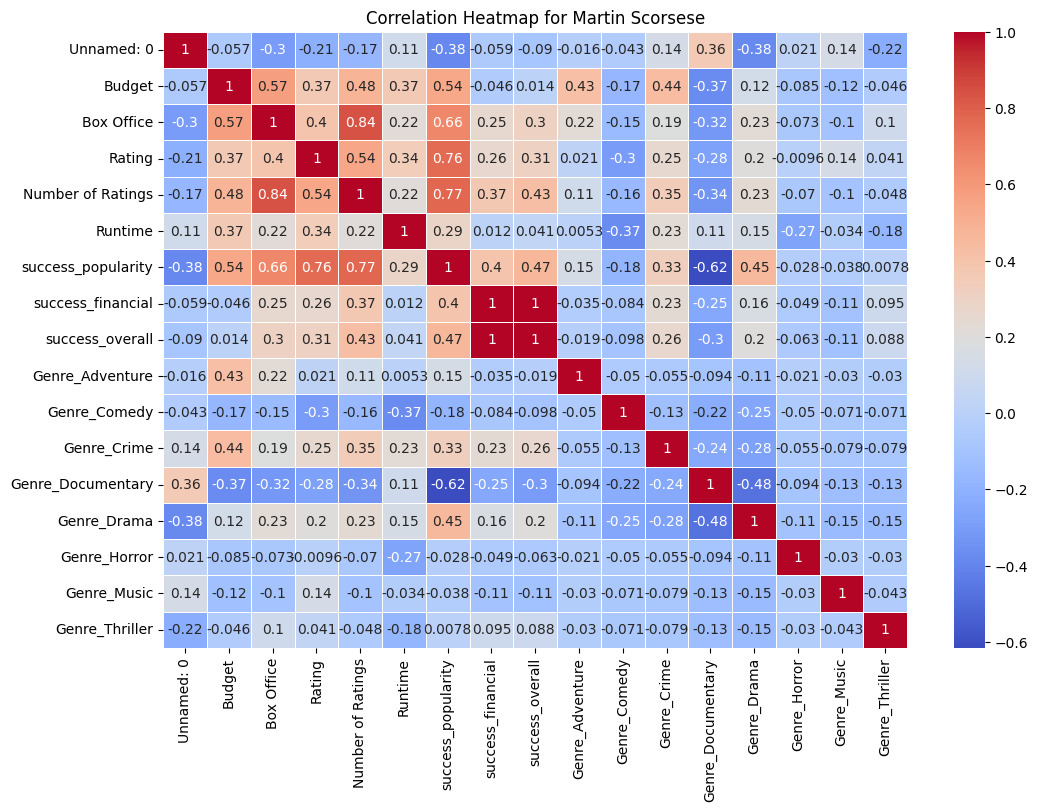

In [1281]:
director_name = 'Martin Scorsese'

director_data = movie_dataframe[movie_dataframe['Director Name'] == director_name]

# One-hot encode the 'Genre' variable
director_data_encoded = pd.get_dummies(director_data, columns=['Genre'])

correlation_matrix = director_data_encoded.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title(f'Correlation Heatmap for {director_name}')
plt.show()

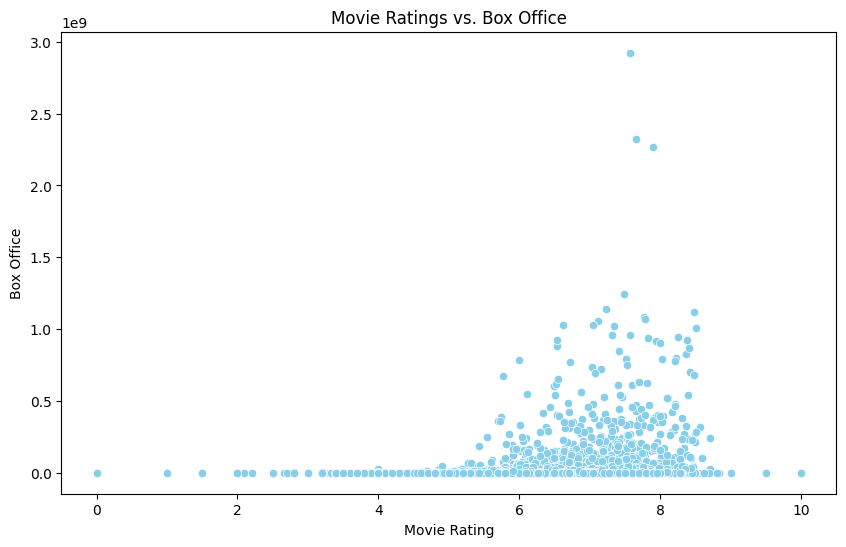

In [1282]:
# Retrieve Movie Rating and Box Office columns
movie_ratings = movie_dataframe['Rating']
box_office = movie_dataframe['Box Office']

# Create a scatter plot for Movie Ratings vs. Box Office
plt.figure(figsize=(10, 6))
sns.scatterplot(x=movie_ratings, y=box_office, color='skyblue')
plt.title('Movie Ratings vs. Box Office')
plt.xlabel('Movie Rating')
plt.ylabel('Box Office')
plt.show()

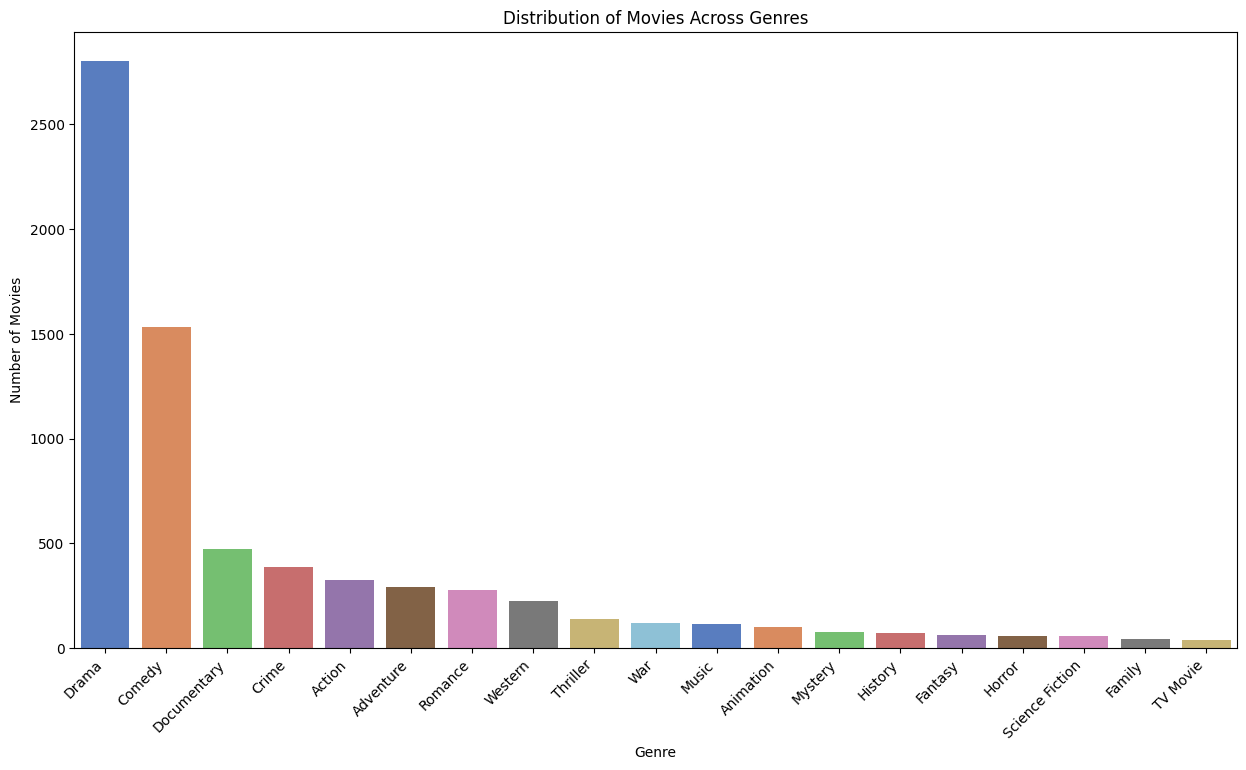

In [1283]:
plt.figure(figsize=(15, 8))
genre_distribution = movie_dataframe['Genre'].value_counts()
sns.barplot(x=genre_distribution.index, y=genre_distribution.values, palette='muted')
plt.title('Distribution of Movies Across Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.show()


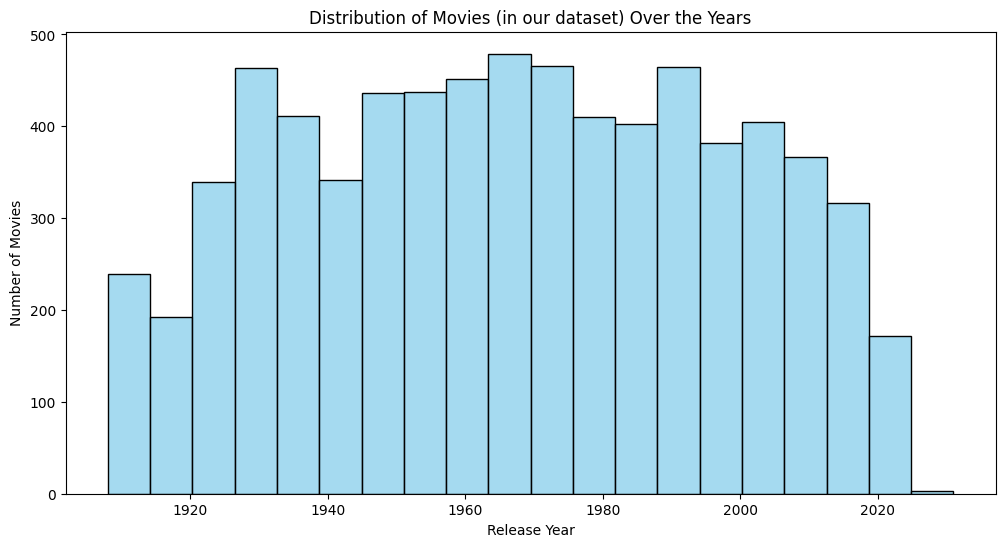

In [1284]:
plt.figure(figsize=(12, 6))
sns.histplot(movie_dataframe['Date of Release'].dt.year, bins=20, kde=False, color='skyblue')
plt.title('Distribution of Movies (in our dataset) Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.show()



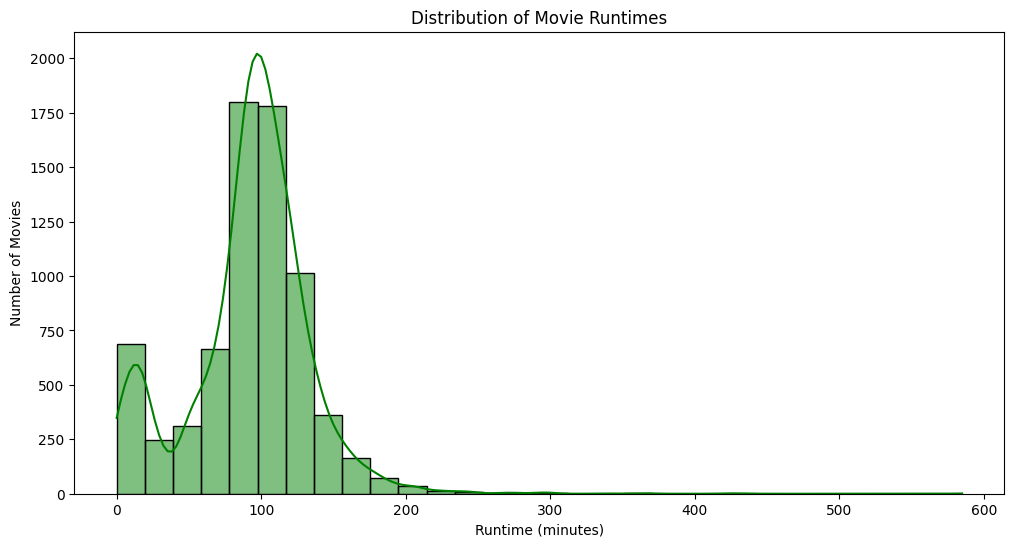

In [1285]:
plt.figure(figsize=(12, 6))
sns.histplot(movie_dataframe['Runtime'], bins=30, kde=True, color='green')
plt.title('Distribution of Movie Runtimes')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Number of Movies')
plt.show()



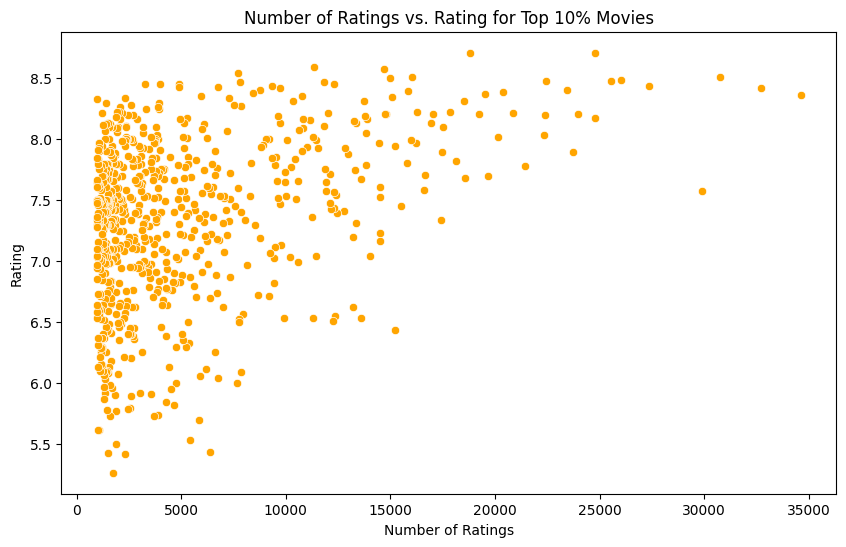

In [1286]:
# Choose a threshold for the top 10% based on the number of ratings
top_percent_threshold = 0.1

# Sort the dataframe by 'Number of Ratings' in descending order
sorted_movies = movie_dataframe.sort_values(by='Number of Ratings', ascending=False)

# Calculate the threshold for the top 10%
top_percent_threshold_index = int(len(sorted_movies) * top_percent_threshold)

# Select the top 10% of movies based on the number of ratings
top_rated_movies = sorted_movies.head(top_percent_threshold_index)

# Scatter plot for Number of Ratings vs. Rating for the top 10% movies
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Number of Ratings', y='Rating', data=top_rated_movies, color='orange')
plt.title('Number of Ratings vs. Rating for Top 10% Movies')
plt.xlabel('Number of Ratings')
plt.ylabel('Rating')
plt.show()

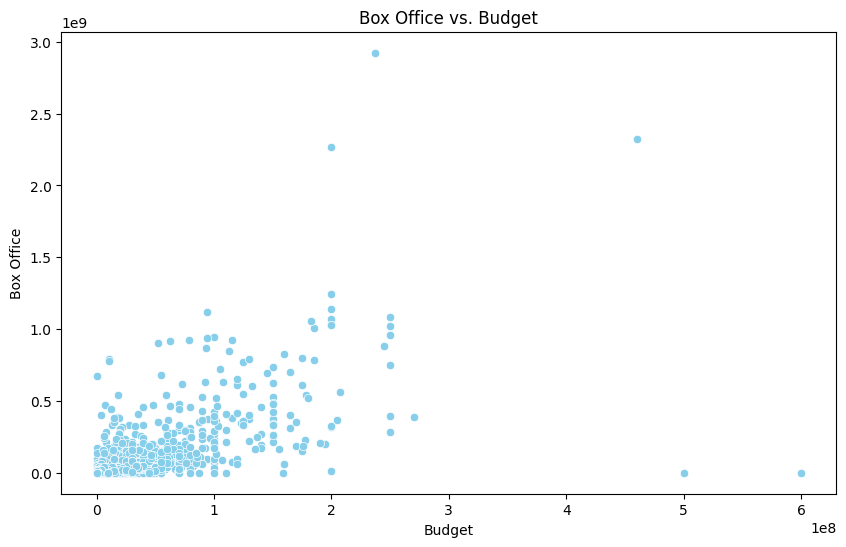

In [1287]:
# Retrieve Box Office and Budget columns
box_office = movie_dataframe['Box Office']
budget = movie_dataframe['Budget']

# Create a scatter plot for Box Office vs. Budget
plt.figure(figsize=(10, 6))
sns.scatterplot(x=budget, y=box_office, color='skyblue')
plt.title('Box Office vs. Budget')
plt.xlabel('Budget')
plt.ylabel('Box Office')
plt.show()

<ipython-input-1288-722e00248a65>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top_directors['Date of Release'] = pd.to_datetime(df_top_directors['Date of Release'])


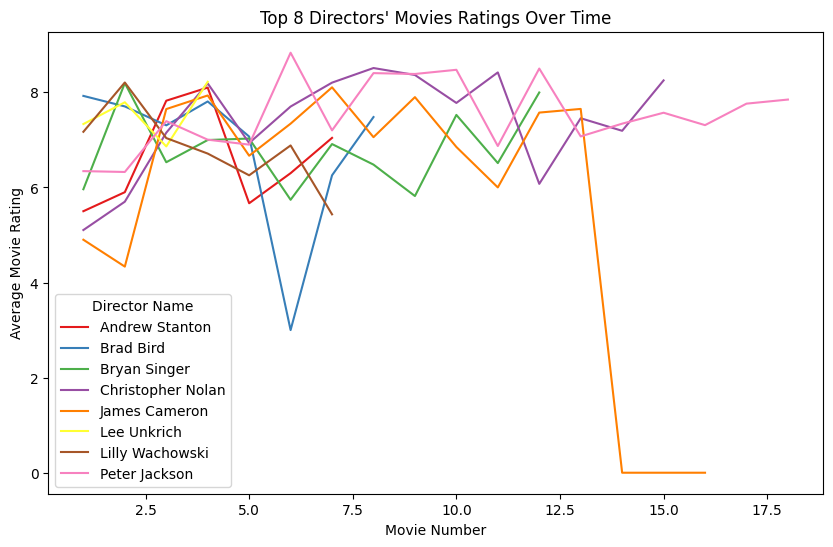

In [1288]:
# Calculate the average box office for each director
director_avg_box_office = movie_dataframe.groupby('Director Name')['Box Office'].mean()

# Identify the top 10 directors based on average box office
top_directors = director_avg_box_office.nlargest(8).index

# Filter the DataFrame for movies by the top 10 directors
df_top_directors = movie_dataframe[movie_dataframe['Director Name'].isin(top_directors)]

# Assuming 'Date of Release' is in datetime format, if not, convert it using pd.to_datetime
df_top_directors['Date of Release'] = pd.to_datetime(df_top_directors['Date of Release'])

# Sort the DataFrame by 'Date of Release' for accurate time-based analysis
df_top_directors = df_top_directors.sort_values(by='Date of Release')

# Calculate the average rating for each movie for each director
df_top_directors['Movie Number'] = df_top_directors.groupby('Director Name').cumcount() + 1
df_avg_ratings_top = df_top_directors.groupby(['Director Name', 'Movie Number']).agg({'Rating': 'mean'}).reset_index()

# Create a line plot for Directors' Movies Ratings Over Time
plt.figure(figsize=(10, 6))
sns.lineplot(x='Movie Number', y='Rating', hue='Director Name', data=df_avg_ratings_top, palette='Set1')
plt.title("Top 8 Directors' Movies Ratings Over Time")
plt.xlabel('Movie Number')
plt.ylabel('Average Movie Rating')
plt.show()

In [1289]:
# sns.lineplot(x='Date of Release', y='Rating', hue='Director Name', data=movie_dataframe)
# plt.title('Director\'s Movies Evolution Over Time')
# plt.show()

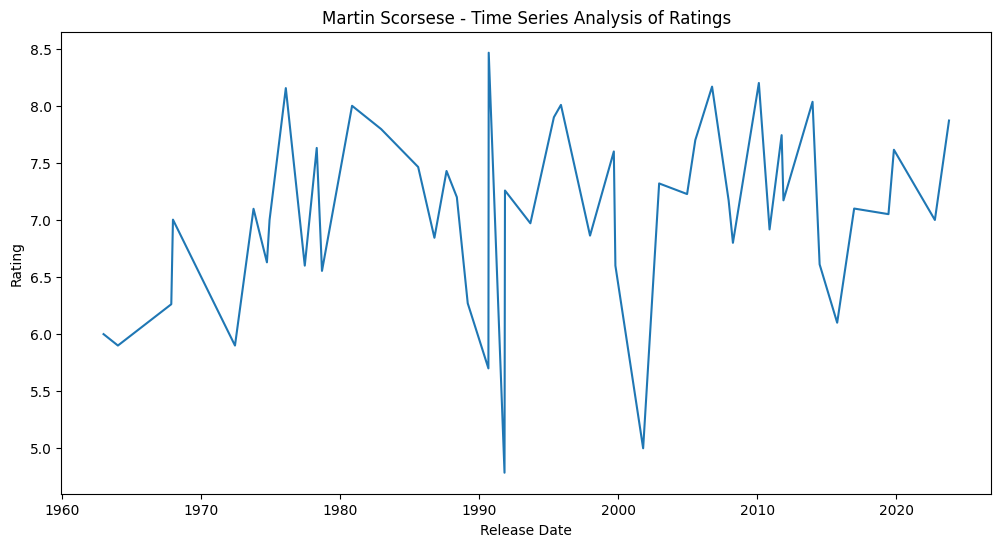

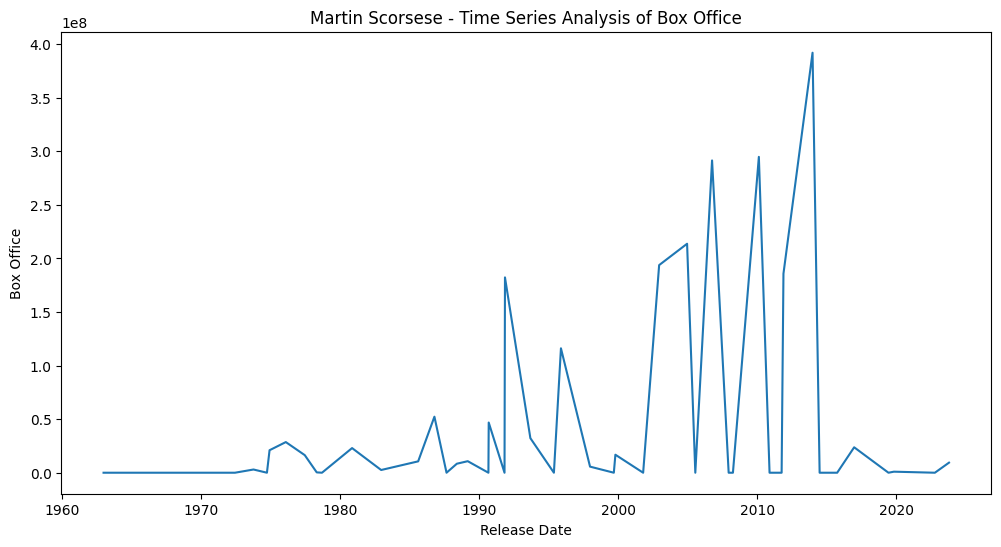

In [1290]:
# Choose a director for analysis
director_name = 'Martin Scorsese'  # REPLACE WITH ANY DIRECTOR

# Filter the data for the selected director
director_data = movie_dataframe[movie_dataframe['Director Name'] == director_name]

# -----------------------HOW GIVEN DIRECTORS MOVIE RATINGS HAVE CHANGED OVER TIME----------------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date of Release', y='Rating', data=director_data)
plt.title(f'{director_name} - Time Series Analysis of Ratings')
plt.xlabel('Release Date')
plt.ylabel('Rating')
plt.show()

# ------------------------HOW GIVEN DIRECTORS BOX OFFICE HAS CHANGED OVER TIME----------------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date of Release', y='Box Office', data=director_data)
plt.title(f'{director_name} - Time Series Analysis of Box Office')
plt.xlabel('Release Date')
plt.ylabel('Box Office')
plt.show()

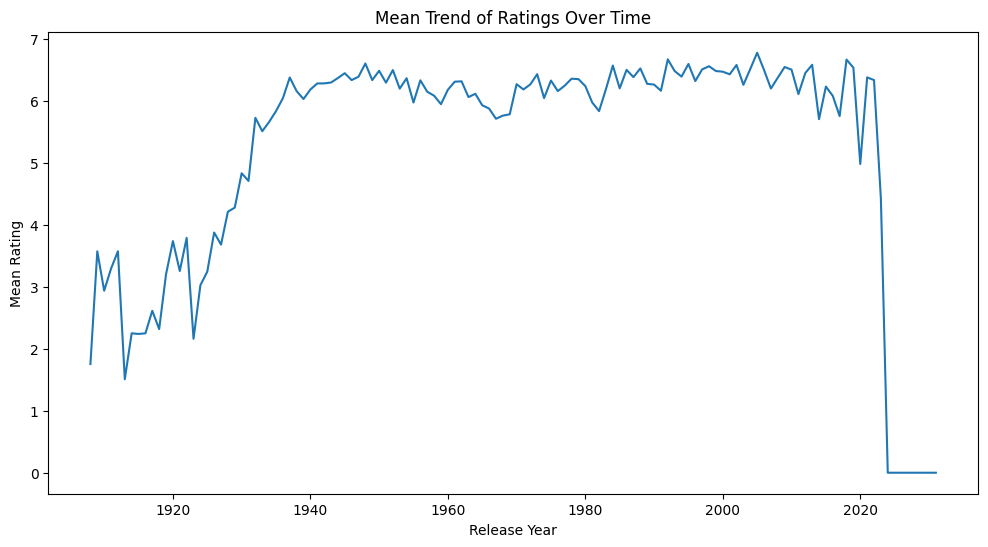

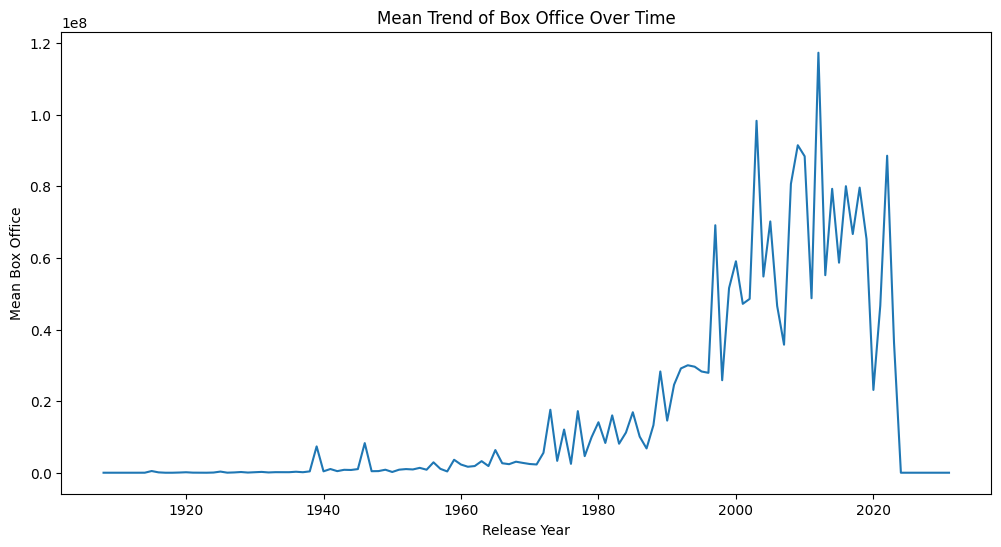

In [1291]:
# Because 'DateofRelease' is a datetime column
movie_dataframe['Year'] = movie_dataframe['Date of Release'].dt.year

# -----------------------HOW DIRECTORS MOVIE RATINGS HAVE CHANGED OVER TIME (GENERAL TREND)----------------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Rating', data=movie_dataframe.groupby('Year')['Rating'].mean().reset_index())
plt.title('Mean Trend of Ratings Over Time')
plt.xlabel('Release Year')
plt.ylabel('Mean Rating')
plt.show()

# ------------------------HOW GIVEN DIRECTORS BOX OFFICE HAS CHANGED OVER TIME (GENERAL TREND)----------------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Box Office', data=movie_dataframe.groupby('Year')['Box Office'].mean().reset_index())
plt.title('Mean Trend of Box Office Over Time')
plt.xlabel('Release Year')
plt.ylabel('Mean Box Office')
plt.show()

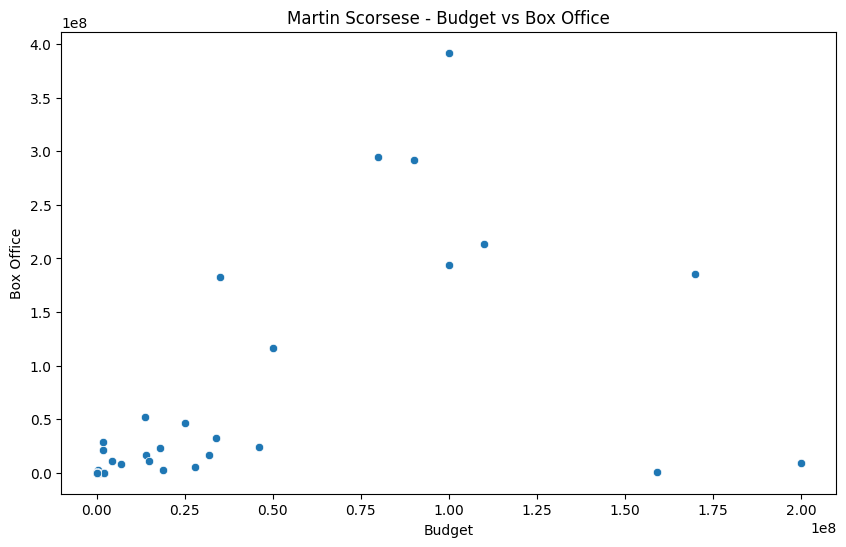

Correlation Coefficient between Box Office and Budget: 0.5722811679369149


In [1292]:
import numpy as np

# Choose a director for analysis
director_name = 'Martin Scorsese'

# Filter the data for the selected director
director_data = movie_dataframe[movie_dataframe['Director Name'] == director_name]

# -----------------------------------------Scatter plot for Budget vs Box Office------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Budget', y='Box Office', data=director_data)
plt.title(f'{director_name} - Budget vs Box Office')
plt.xlabel('Budget')
plt.ylabel('Box Office')
plt.show()

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(director_data['Budget'], director_data['Box Office'])[0, 1]
print(f'Correlation Coefficient between Box Office and Budget: {correlation_coefficient}')

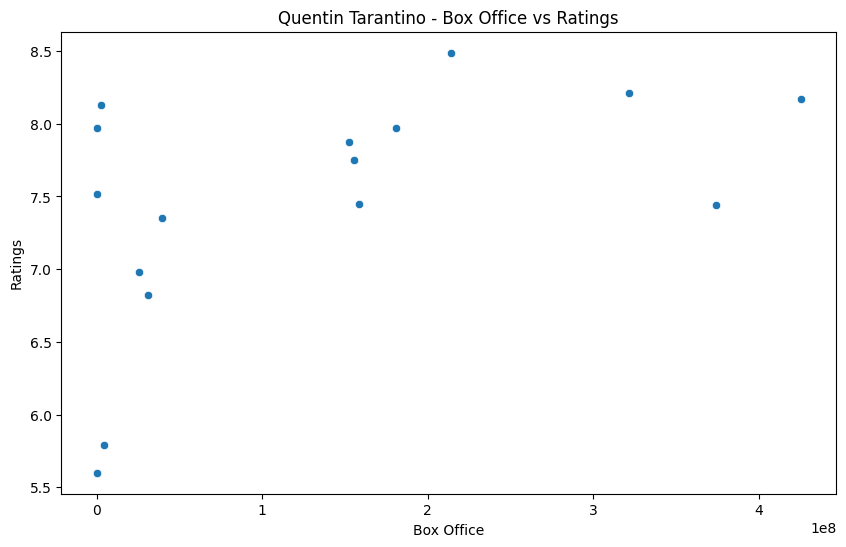

Correlation Coefficient between Rating and Box Office: 0.5036247880169472


In [1293]:
# Choose a director for analysis
director_name = 'Quentin Tarantino'

# Filter the data for the selected director
director_data = movie_dataframe[movie_dataframe['Director Name'] == director_name]

# -------------------------------Scatter plot for Box Office vs Ratings----------------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Box Office', y='Rating', data=director_data)
plt.title(f'{director_name} - Box Office vs Ratings')
plt.xlabel('Box Office')
plt.ylabel('Ratings')
plt.show()

# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(director_data['Box Office'], director_data['Rating'])[0, 1]
print(f'Correlation Coefficient between Rating and Box Office: {correlation_coefficient}')

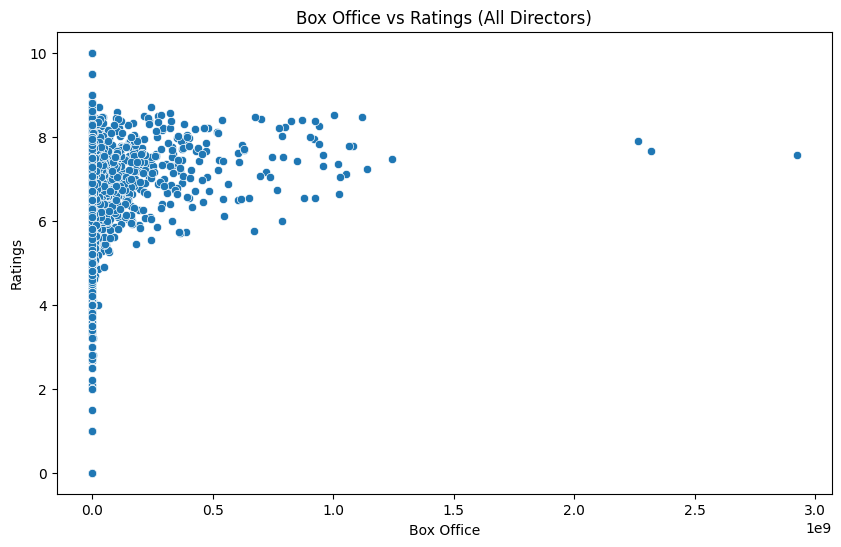

Correlation Coefficient between Box Office and Ratings (All Directors): 0.12291703352433883


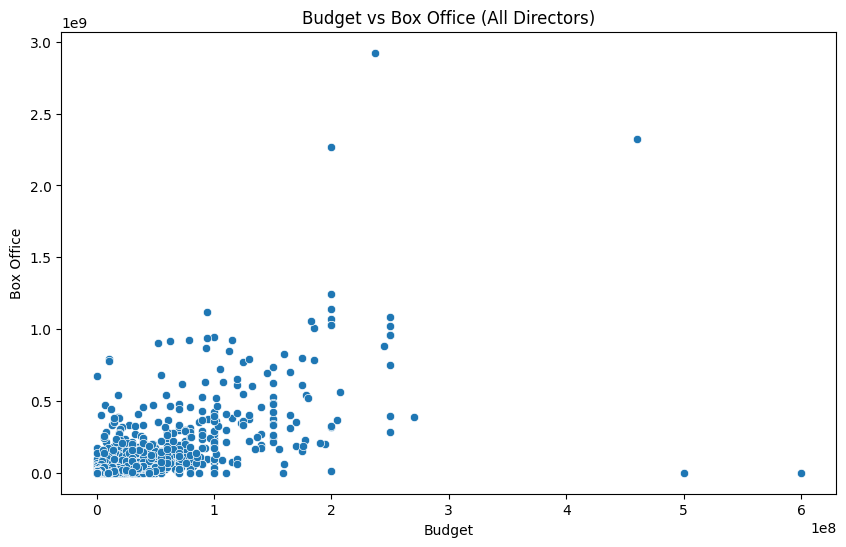

Correlation Coefficient between Budget and Box Office (All Directors): 0.7099860277438924


In [1294]:
# -----------------Scatter plot for Box Office vs Ratings (All Directors)----------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Box Office', y='Rating', data=movie_dataframe)
plt.title('Box Office vs Ratings (All Directors)')
plt.xlabel('Box Office')
plt.ylabel('Ratings')
plt.show()

# Calculate the correlation coefficient for all directors
correlation_coefficient_box_office_ratings = np.corrcoef(movie_dataframe['Box Office'], movie_dataframe['Rating'])[0, 1]
print(f'Correlation Coefficient between Box Office and Ratings (All Directors): {correlation_coefficient_box_office_ratings}')

# ------------------Scatter plot for Budget vs Box Office (All Directors)--------------------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Budget', y='Box Office', data=movie_dataframe)
plt.title('Budget vs Box Office (All Directors)')
plt.xlabel('Budget')
plt.ylabel('Box Office')
plt.show()

# Calculate the correlation coefficient for all directors
correlation_coefficient_budget_box_office = np.corrcoef(movie_dataframe['Budget'], movie_dataframe['Box Office'])[0, 1]
print(f'Correlation Coefficient between Budget and Box Office (All Directors): {correlation_coefficient_budget_box_office}')

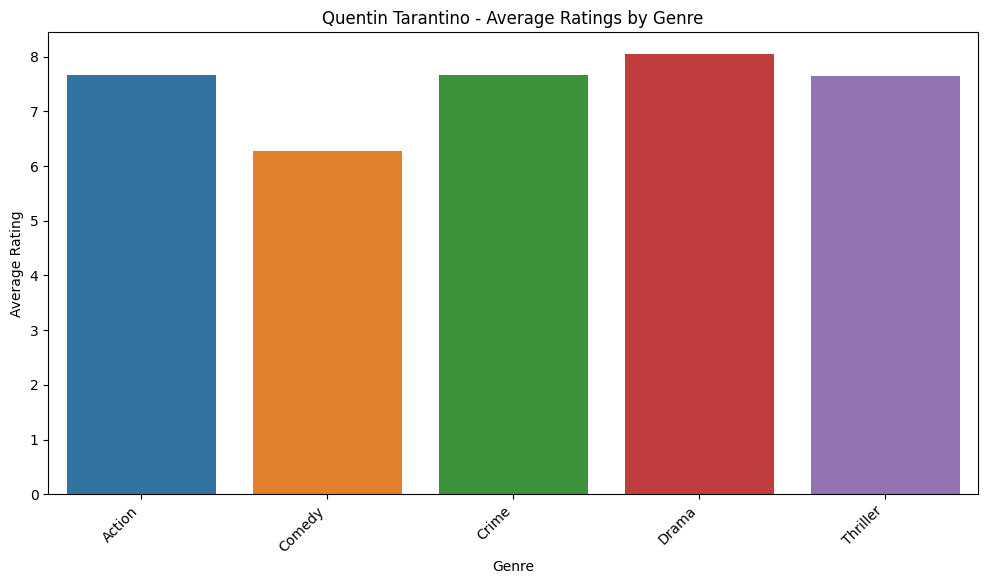

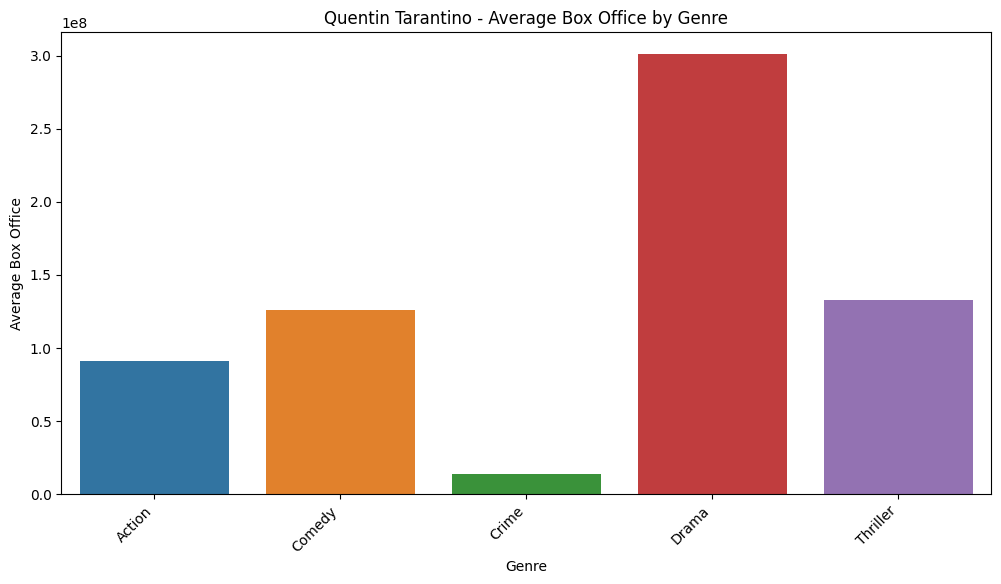

In [1295]:
# Choose a director for analysis
director_name = 'Quentin Tarantino'

# Filter the data for the selected director
director_data = movie_dataframe[movie_dataframe['Director Name'] == director_name]

# Group data by genre and calculate average ratings and box office
average_data = director_data.groupby('Genre').agg({'Rating': 'mean', 'Box Office': 'mean'}).reset_index()

# -----------------------Plotting average ratings by genre---------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='Rating', data=average_data)
plt.title(f'{director_name} - Average Ratings by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.show()

# -----------------------Plotting average box office by genre--------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(x='Genre', y='Box Office', data=average_data)
plt.title(f'{director_name} - Average Box Office by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Box Office')
plt.xticks(rotation=45, ha='right')
plt.show()

<ipython-input-1296-4b7eebdfb562>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  director_data['Release Month'] = director_data['Date of Release'].dt.month


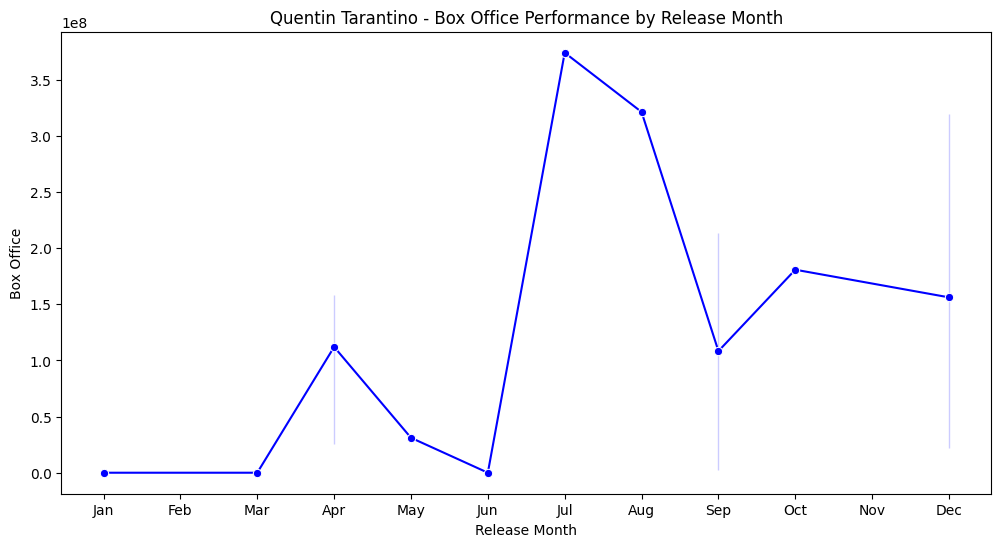

In [1296]:
# Choose a director for analysis
director_name = 'Quentin Tarantino'

# Filter the data for the selected director
director_data = movie_dataframe[movie_dataframe['Director Name'] == director_name]

# Extract month from the 'DateofRelease'
director_data['Release Month'] = director_data['Date of Release'].dt.month

# ------------------------Line plot for box office performance by release month-------------------------
plt.figure(figsize=(12, 6))
sns.lineplot(x='Release Month', y='Box Office', data=director_data, marker='o', color='b')
plt.title(f'{director_name} - Box Office Performance by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Box Office')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [1297]:
print(movie_dataframe.columns.tolist())

['Unnamed: 0', 'Director Name', 'Title', 'Budget', 'Box Office', 'Rating', 'Number of Ratings', 'Genre', 'Date of Release', 'Production House', 'Runtime', 'success_popularity', 'success_financial', 'success_overall', 'Year']


In [1298]:
movie_dataframe.head

<bound method NDFrame.head of       Unnamed: 0      Director Name                             Title  Budget  \
0              0      Ertem Egilmez  The Chaos Class Failed the Class     0.0   
1              1      Ertem Egilmez                         Arabesque     0.0   
3              3      Ertem Egilmez                      Smiling Eyes     0.0   
4              4      Ertem Egilmez                     The Blue Bead     0.0   
5              5      Ertem Egilmez                   My Dear Brother     0.0   
...          ...                ...                               ...     ...   
8642        8642  Mikhail Kalatozov                     Their Kingdom     0.0   
8643        8643  Mikhail Kalatozov                  Wings of Victory     0.0   
8644        8644  Mikhail Kalatozov                Hostile Whirlwinds     0.0   
8645        8645  Mikhail Kalatozov                           Courage     0.0   
8646        8646  Mikhail Kalatozov                    The Invincible     0.0  

# Training machine learning model

In [1299]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GroupShuffleSplit

In [1300]:
# creating new df called movie_dataframe_ml to play around with for the ML part
movie_dataframe_ml = movie_dataframe.copy()

scaler = StandardScaler()
movie_dataframe_ml['Budget_Standardized'] = scaler.fit_transform(movie_dataframe_ml[['Budget']])

movie_dataframe_ml['Month'] = movie_dataframe_ml['Date of Release'].dt.month

print("movie_dataframe_ml columns: ")
print(movie_dataframe_ml.columns.tolist())
# print(movie_dataframe_ml.isnull().sum())

# dropping columns:
# "Unnamed: 0" as this is just the index
# "Title": as this is not eneded for the ML model
# "Data of Release": as this has type datetime and cannot be used, and we have the columns "month" and "year" instead
# "Budget": as we have included Budget_Standardized instead
movie_dataframe_ml = movie_dataframe_ml.drop(columns=['Unnamed: 0', 'Title', 'Date of Release', 'Budget'])

# additional columns to drop (as we will not be able to provide these as input to the model for prediction)
movie_dataframe_ml = movie_dataframe_ml.drop(columns=['Box Office', 'Rating', 'Number of Ratings', 'Runtime', 'success_popularity', 'success_financial'])

# one-hot encoding
encoder = OneHotEncoder(handle_unknown='ignore')
categorical_data = movie_dataframe_ml[['Director Name', 'Genre', 'Production House', 'Month']]
categorical_data_encoded = encoder.fit_transform(categorical_data)

# Reset index before concatenating to avoid misalignment problems
encoded_df = pd.DataFrame(categorical_data_encoded.toarray(), columns=encoder.get_feature_names_out())
encoded_df.reset_index(drop=True, inplace=True)

# Reset index of the original dataframe as well
movie_dataframe_ml_reset = movie_dataframe_ml.drop(columns=['Director Name', 'Genre', 'Production House', 'Month']).reset_index(drop=True)

# Combining encoded categorical data with the rest of the dataframe
movie_dataframe_ml_encoded = pd.concat([movie_dataframe_ml_reset, encoded_df], axis=1)

movie_dataframe_ml_encoded.columns = movie_dataframe_ml_encoded.columns.astype(str)

# Select features and target variable
features = movie_dataframe_ml_encoded.drop(columns=['success_overall'])

target = movie_dataframe_ml_encoded['success_overall']

# print(features.isnull().sum())

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# mean_train = X_train.mean(axis=0)
# std_train = X_train.std(axis=0)

# # Standardize the training data
# X_train_scaled = (X_train - mean_train) / std_train

# # Use the mean and standard deviation of the training data to standardize the test data
# X_test_scaled = (X_test - mean_train) / std_train

# Model selection
model = RandomForestRegressor(random_state=42) # bagging
# model = GradientBoostingRegressor(random_state=42) # boosting
# model = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
model.fit(X_train_scaled, y_train)

print("\nX_train columns: ")
print(X_train.columns.tolist())
# print(X_train.isnull().sum())
# Training the model
# model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

movie_dataframe_ml columns: 
['Unnamed: 0', 'Director Name', 'Title', 'Budget', 'Box Office', 'Rating', 'Number of Ratings', 'Genre', 'Date of Release', 'Production House', 'Runtime', 'success_popularity', 'success_financial', 'success_overall', 'Year', 'Budget_Standardized', 'Month']

X_train columns: 
['Year', 'Budget_Standardized', 'Director Name_Abbas Kiarostami', 'Director Name_Aki Kaurismäki', 'Director Name_Akira Kurosawa', 'Director Name_Alain Resnais', 'Director Name_Alan Parker', 'Director Name_Alfonso Cuarón', 'Director Name_Alfred Hitchcock', 'Director Name_Andrei Tarkovsky', 'Director Name_Andrew Stanton', 'Director Name_Andrzej Wajda', 'Director Name_Ang Lee', 'Director Name_Anurag Kashyap', 'Director Name_Arthur Penn', 'Director Name_Asghar Farhadi', 'Director Name_Ashutosh Gowariker', 'Director Name_Atif Yilmaz', 'Director Name_Billy Wilder', 'Director Name_Blake Edwards', "Director Name_Bozidar 'Bota' Nikolic", 'Director Name_Brad Bird', 'Director Name_Brian De Palma',

In [1301]:
# Model evaluation

# metrics for evaluation on training set:
predictions_train = model.predict(X_train_scaled)
mse_train = mean_squared_error(y_train, predictions_train)
mae_train = mean_absolute_error(y_train, predictions_train)
rmse_train = np.sqrt(mse_train)
mean_target_train = y_train.mean()

print("Metrics for training set: ")
print(f'Mean Squared Error: {mse_train}')
print(f'Mean absolute Error: {mae_train}')
print(f'Root Mean Squared Error: {rmse_train}')
print(f'Mean over_all score for movies: {mean_target_train}')

# metrics for evaluation on test set:
predictions = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
mean_target = y_train.mean()

print("\nMetrics for test set: ")
print(f'Mean Squared Error: {mse}')
print(f'Mean absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean over_all score for movies: {mean_target}')


Metrics for training set: 
Mean Squared Error: 23795.106040349983
Mean absolute Error: 30.350855964508213
Root Mean Squared Error: 154.25662397560106
Mean over_all score for movies: 73.2887074878347

Metrics for test set: 
Mean Squared Error: 316186.51542012923
Mean absolute Error: 87.6888118253769
Root Mean Squared Error: 562.3046464507734
Mean over_all score for movies: 73.2887074878347


In [1]:
# print(X_test_scaled)